### Read in final object (only take those barcodes)

In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/subpopulations/Endothelial/final/")
DIR2SAVE.mkdir(parents=True, exist_ok=True)

FIG2SAVE = DIR2SAVE.joinpath("figures/after_20mt_sam_annot_merge/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [3]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath(
        "SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_Endothelial_final.h5ad"
    )
)
adata.shape

(3051, 2000)

In [4]:
adata_all = sc.read_h5ad("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/20mt/SMC_KUL_Pelka_Che_Wu_pCRC_annotations.h5ad")

In [5]:
barcodes2keep = adata_all[adata_all.obs.Annotation_scVI=="Endothelial"].obs.index
len(barcodes2keep)

3047

In [6]:
# select only barcodees that are in final object (20mt sam + my TME)
adata = adata[adata.obs.index.isin(barcodes2keep)].copy()
adata.shape

(3047, 2000)

In [7]:
adata.obs.Annotation_scVI_detailed.cat.categories

Index(['Endo cycling', 'Lymphatic endo', 'Stalk-like endo', 'Tip-like endo'], dtype='object')

# change colours

In [8]:
adata.uns["Annotation_scVI_detailed_colors"] = ["#fee391",
                                                "#b2df8a", #"#d9f0a3",
                                                "#a6cee3", #"#8ae7ae",
                                                "#1f78b4"#"#ae8ae7"
                                               ]

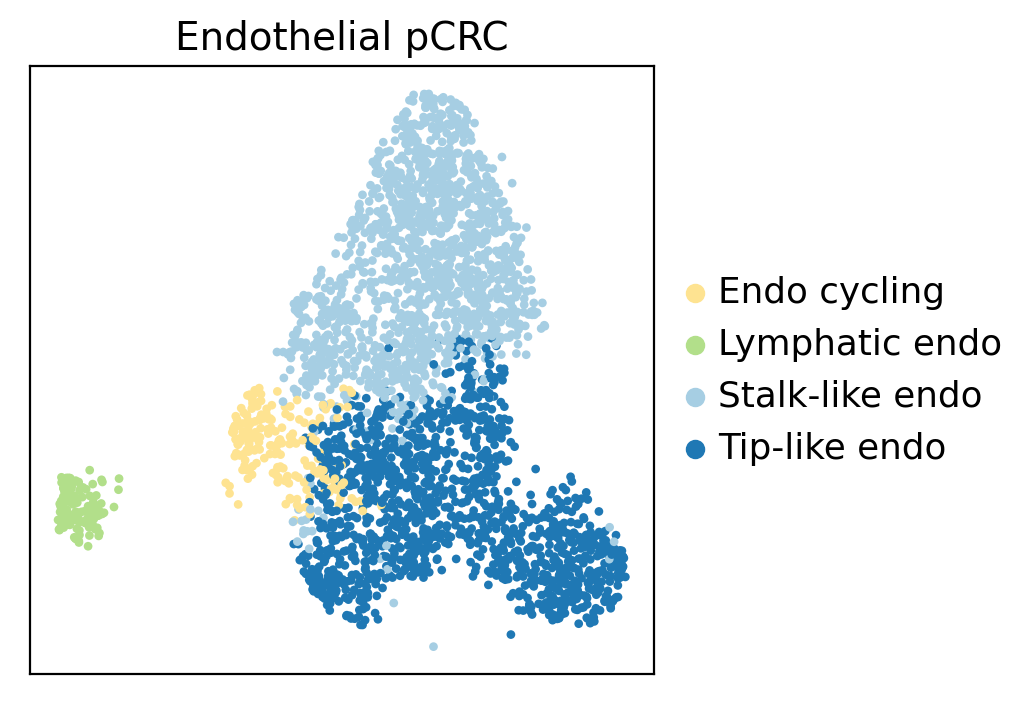

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed",
    show=False,
    legend_loc="right margin",
    title="Endothelial pCRC",
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig(FIG2SAVE.joinpath("Annotation.pdf"), bbox_inches='tight', dpi=DPI)

In [10]:
markers = {
    #"Endo": ["PECAM1", "PLVAP"],
    "Prolif endo": ["BIRC5", "MKI67"],
    "Lymphatic endo": ["LYVE1", "PROX1"],
    "Stalk": ["ACKR1", "SELP"],
    "Tip": ["RGCC", "KDR"],
    #"Enteric glial": ["S100B", "PLP1"],
    # "Arterial": ["EFNB2"],
}

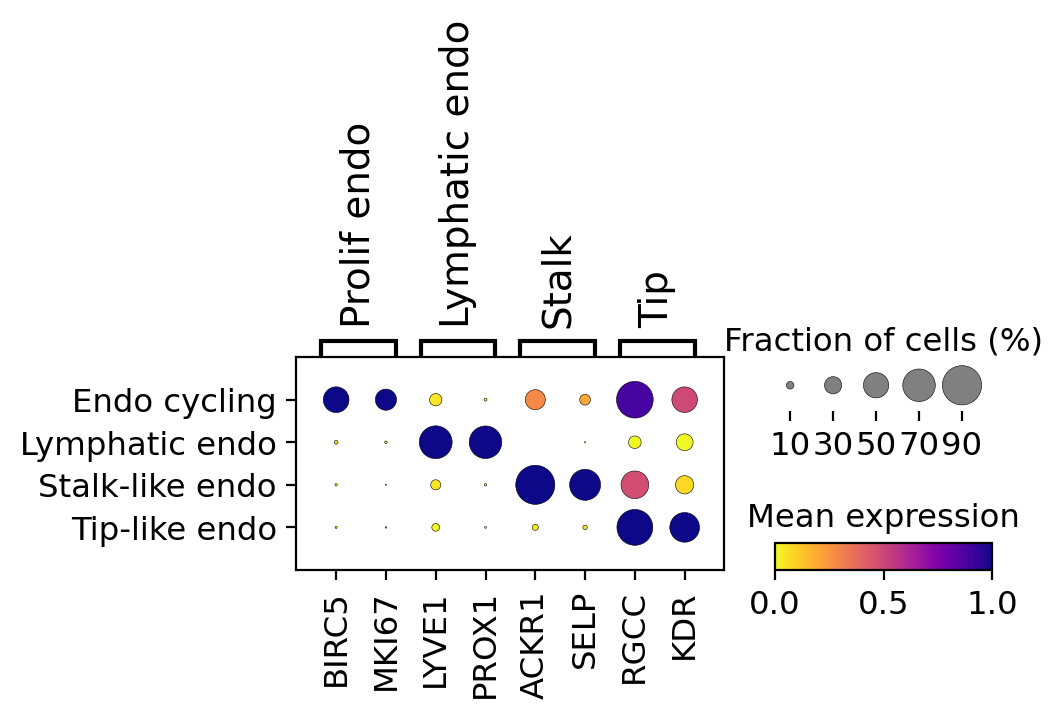

In [11]:
sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI_detailed",
    use_raw=True,
    var_names=markers,
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    size_title = "Fraction of cells (%)",
    #dot_max=0.5,
    save="Endothelial_dotplot_mean_general_annotations.pdf",
    show=True,
)

### zscore

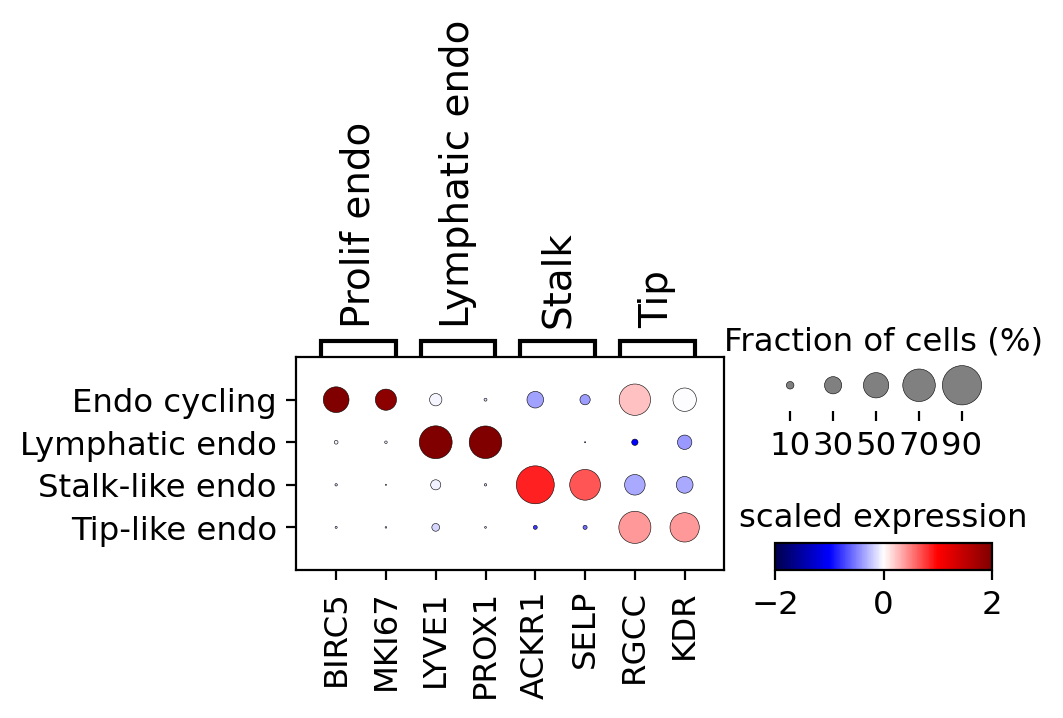

In [12]:
adata_zscore = adata.raw.to_adata().copy()
# scale and store results in layer for later plotting
adata_zscore.layers['scaled'] = sc.pp.scale(adata_zscore, copy=True).X
adata_zscore.obs=adata.obs
sc.pl.dotplot(adata=adata_zscore, 
              var_names=markers,
              groupby="Annotation_scVI_detailed",
              cmap="seismic", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              #dot_max=0.5, 
              colorbar_title = "scaled expression", 
              size_title="Fraction of cells (%)",
              save='zscore_general.pdf')

In [13]:
FIG2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/subpopulations/Endothelial/final/figures/after_20mt_sam_annot_merge')

In [14]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, colors: dict, figname: str, bbox_to_anchor=(1, 0.8)
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        sharey=False,
        sharex=False,
        dpi=DPI,
    )  # figsize=(4, 4))

    print(table2plot)
    table2plot.plot.barh(stacked=True, ax=ax, color=colors.values())  # , color=colors
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())
    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]
    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=bbox_to_anchor, #(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(FIG2SAVE.joinpath(figname), dpi=DPI, format="pdf", bbox_inches="tight")
    plt.show()

cell_source                     SMC        KUL      Pelka        Che
Annotation_scVI_detailed                                            
Endo cycling              25.352113   3.286385  70.892019   0.469484
Lymphatic endo            20.472441  24.409449  21.259843  33.858268
Stalk-like endo           19.609262  14.327062  61.939219   4.124457
Tip-like endo             19.320755  13.132075  63.320755   4.226415


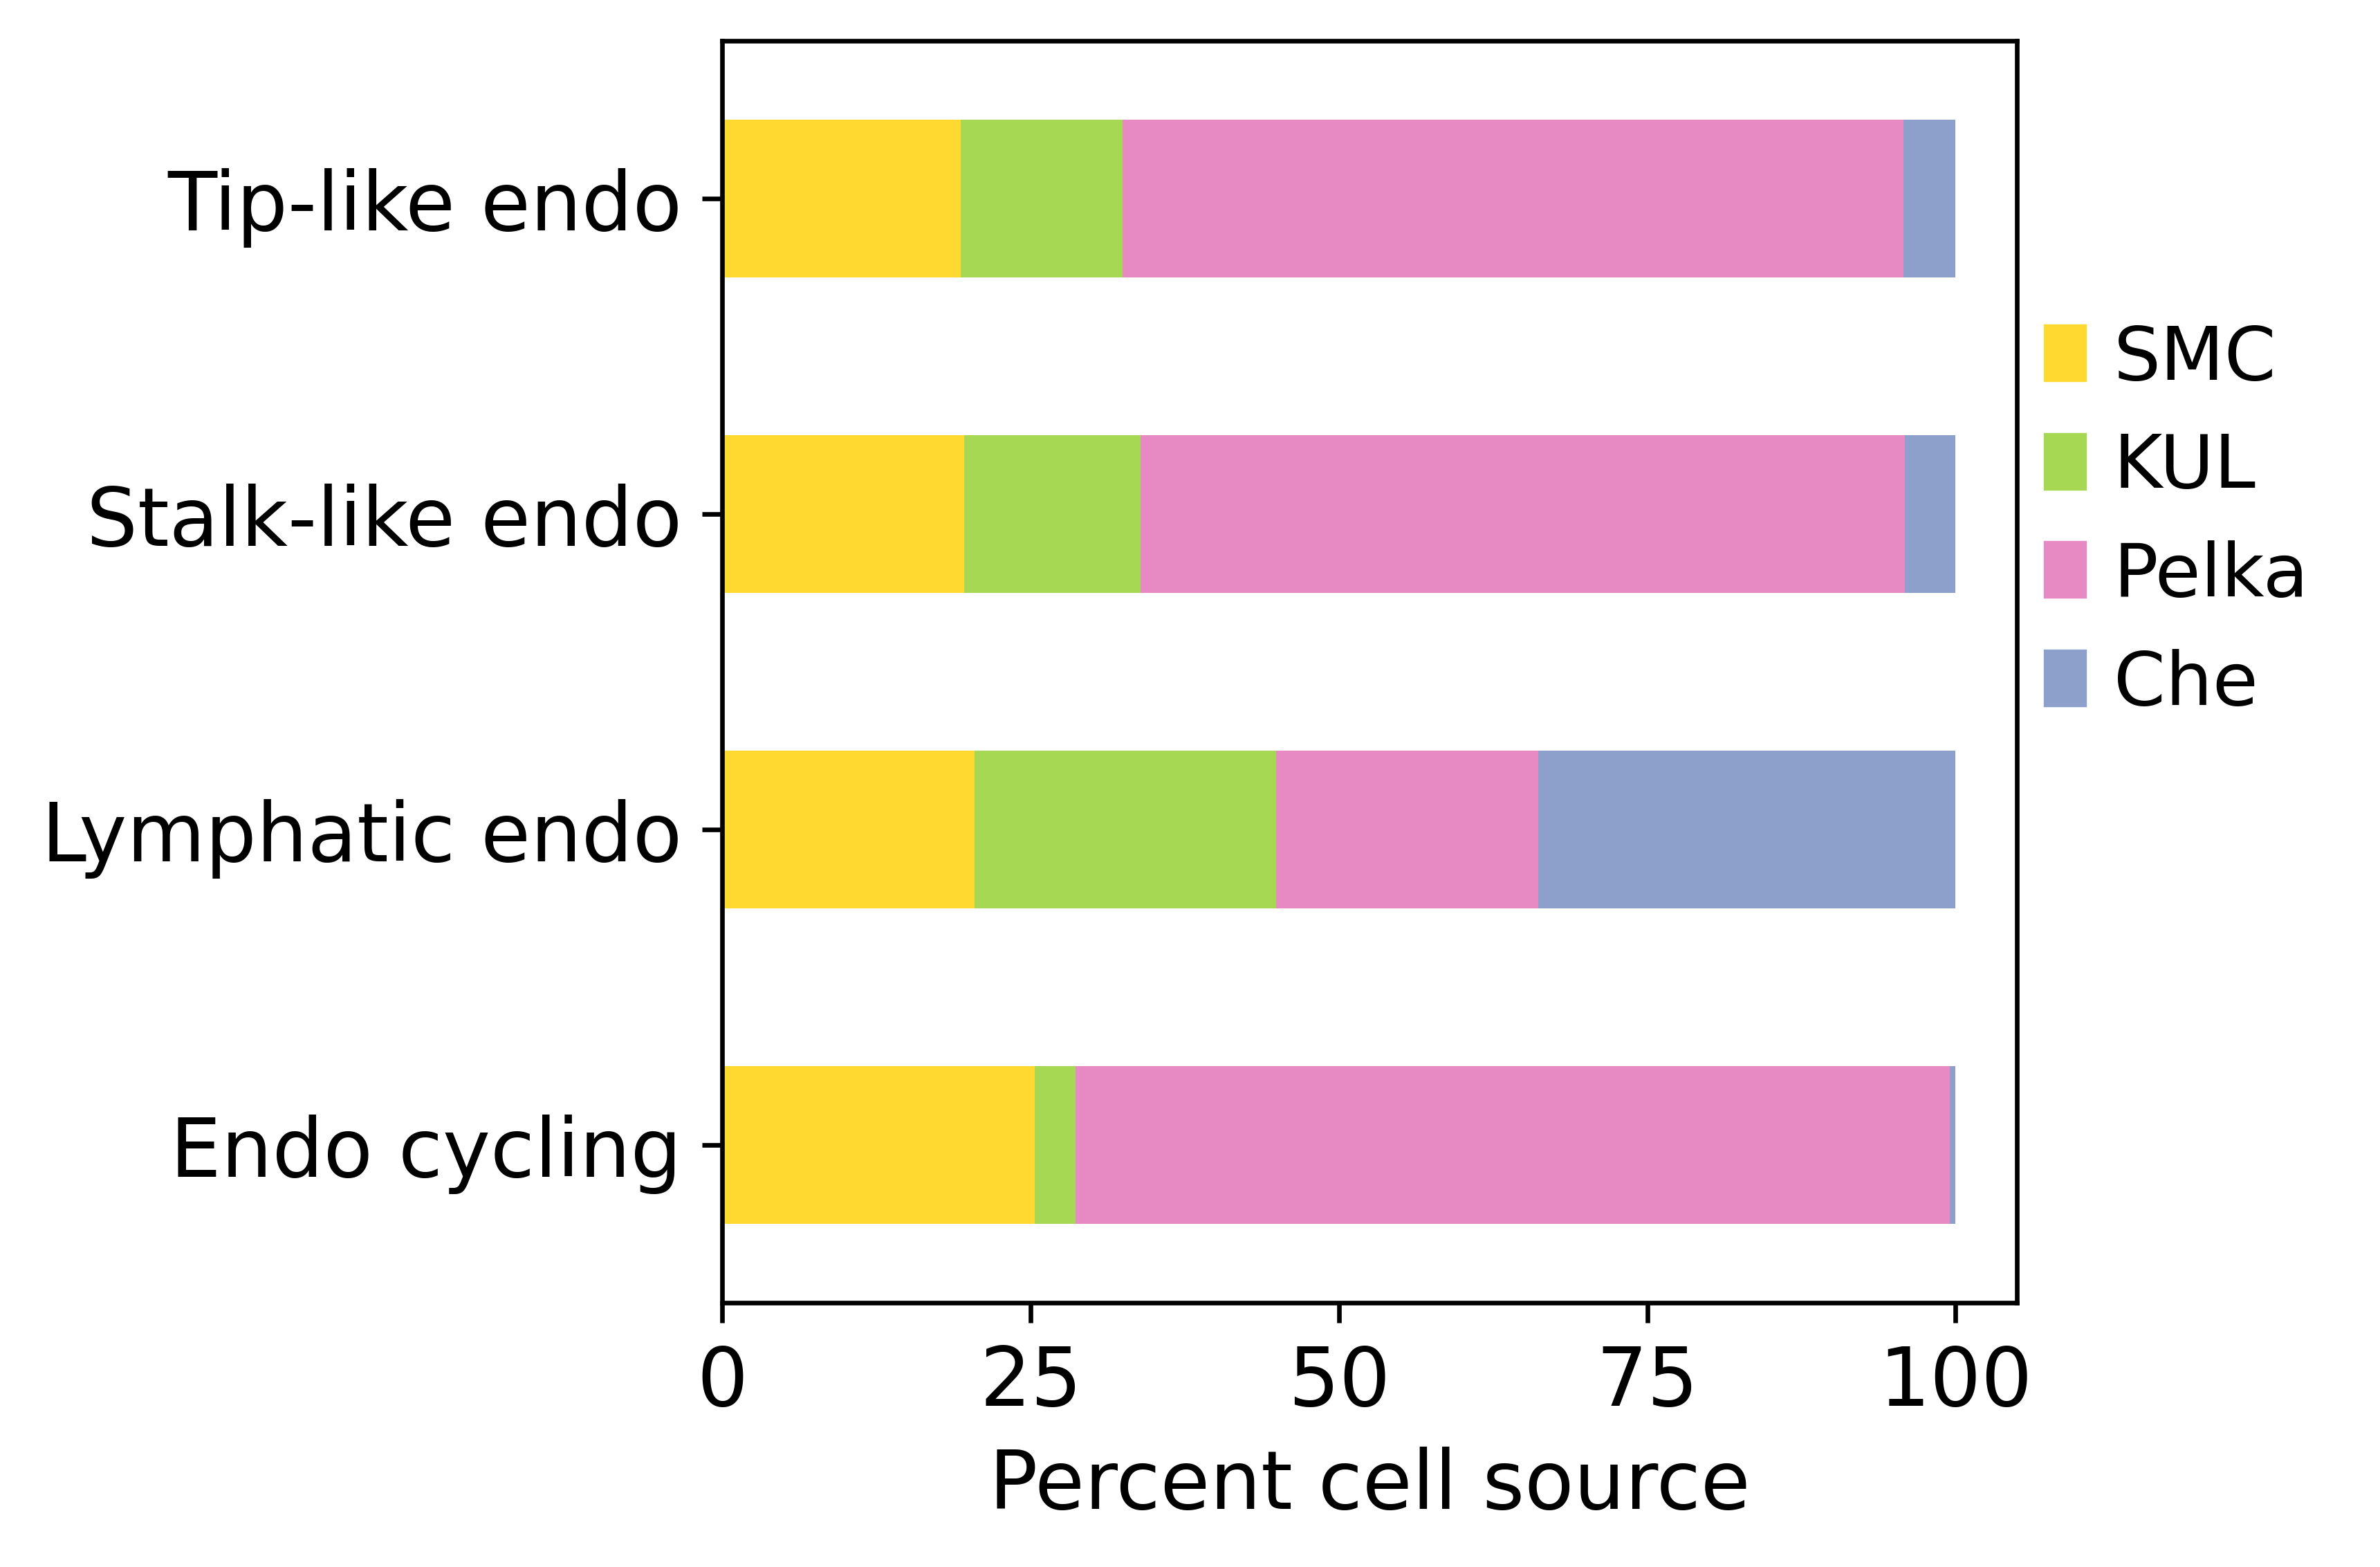

In [15]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["cell_source"].cat.categories.values.tolist(),
        adata.uns["cell_source_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["Annotation_scVI_detailed", "cell_source"],
    xlabel="Percent cell source",
    ylabel="",
    colors=color_dict,
    figname="annotation_cell_source.pdf",
)

In [16]:
FIG2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/subpopulations/Endothelial/final/figures/after_20mt_sam_annot_merge')

Annotation_scVI_detailed  Endo cycling  Lymphatic endo  Stalk-like endo  \
cell_source                                                               
SMC                           8.896211        4.283361        44.645799   
KUL                           1.707317        7.560976        48.292683   
Pelka                         8.061933        1.441538        45.702082   
Che                           0.636943       27.388535        36.305732   

Annotation_scVI_detailed  Tip-like endo  
cell_source                              
SMC                           42.174629  
KUL                           42.439024  
Pelka                         44.794447  
Che                           35.668790  


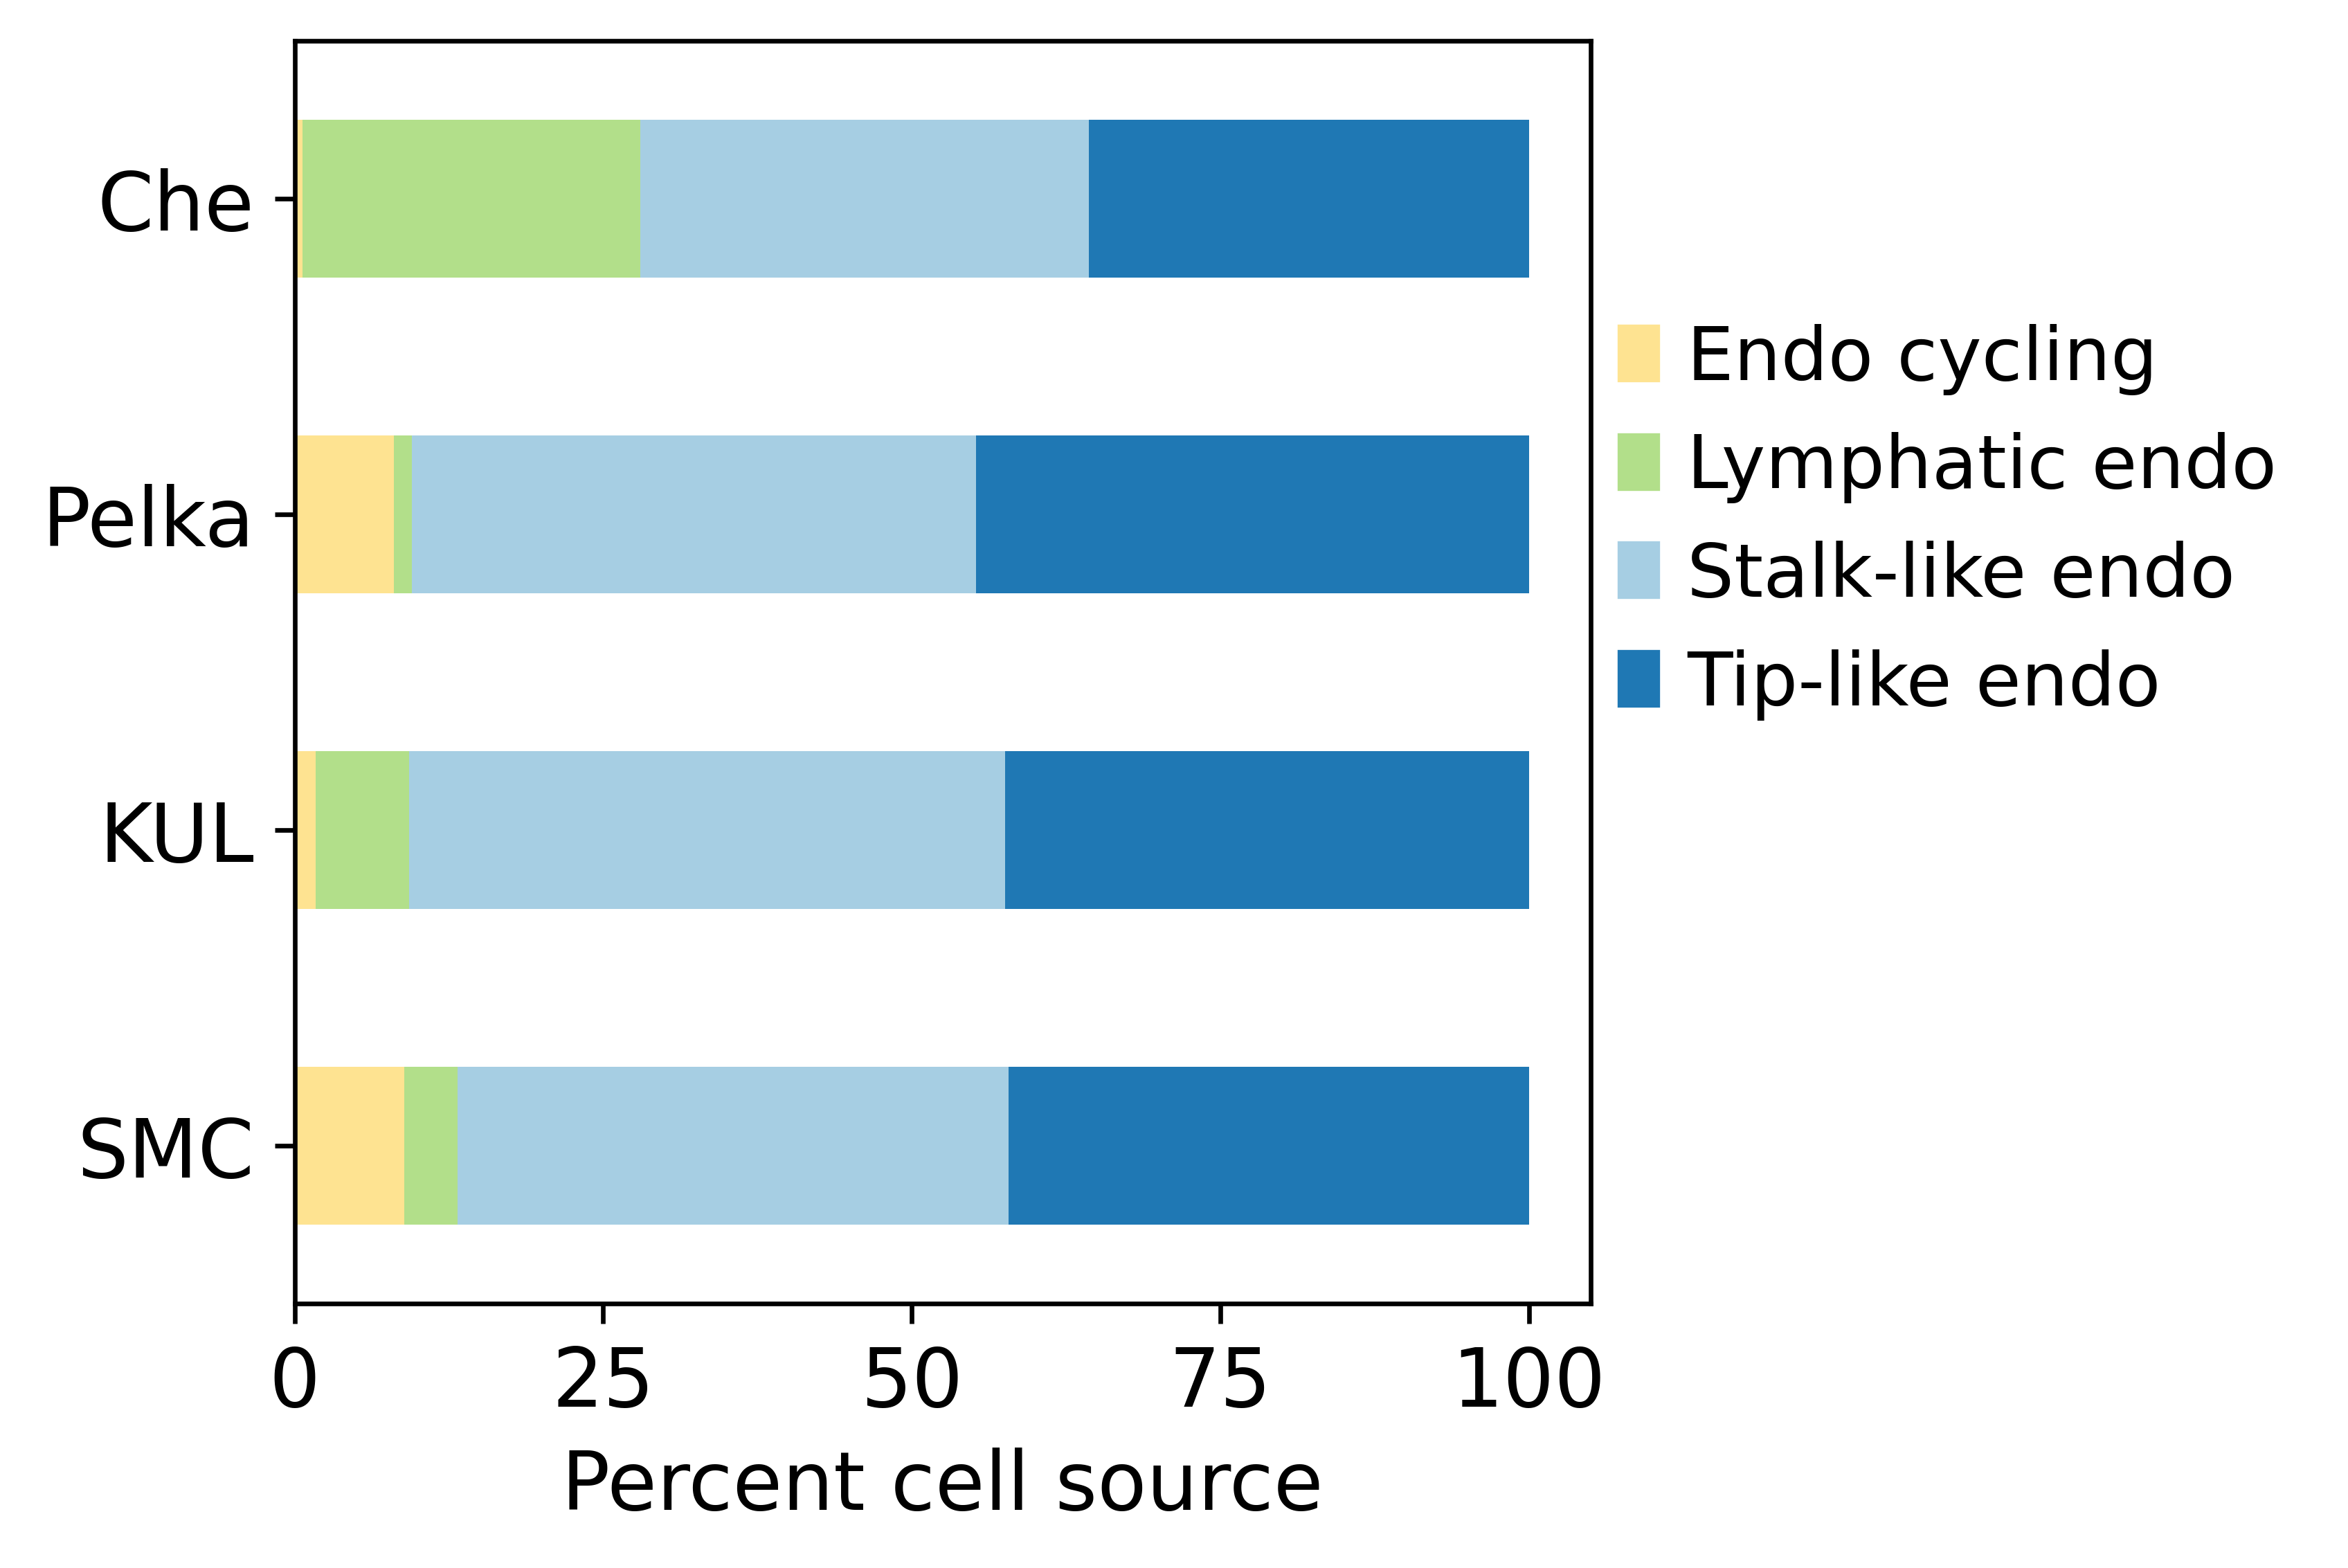

In [17]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["Annotation_scVI_detailed"].cat.categories.values.tolist(),
        adata.uns["Annotation_scVI_detailed_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["cell_source", "Annotation_scVI_detailed"],
    xlabel="Percent cell source",
    ylabel="",
    colors=color_dict,
    figname="barplot_annotation_across_cell_source.pdf",
)

In [18]:
FIG2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/subpopulations/Endothelial/final/figures/after_20mt_sam_annot_merge')